<a href="https://colab.research.google.com/github/JulioHenri/S-ries-Temporais/blob/main/projeto_final_globo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Séries Temporais
### Analisando as ações da Globo

Nos foi disponibilizado pelo professor de Análise de Séries Temporais alguns datasets, nos quais tínhamos que escolher um e aplicar os conhecimentos técnicos ensinados em aula, respeitando alguns pressupostos teóricos, e avaliar o modelo feito, buscando a melhor performance possível.

Então, optei pelos dados de preço das ações da Globo. 


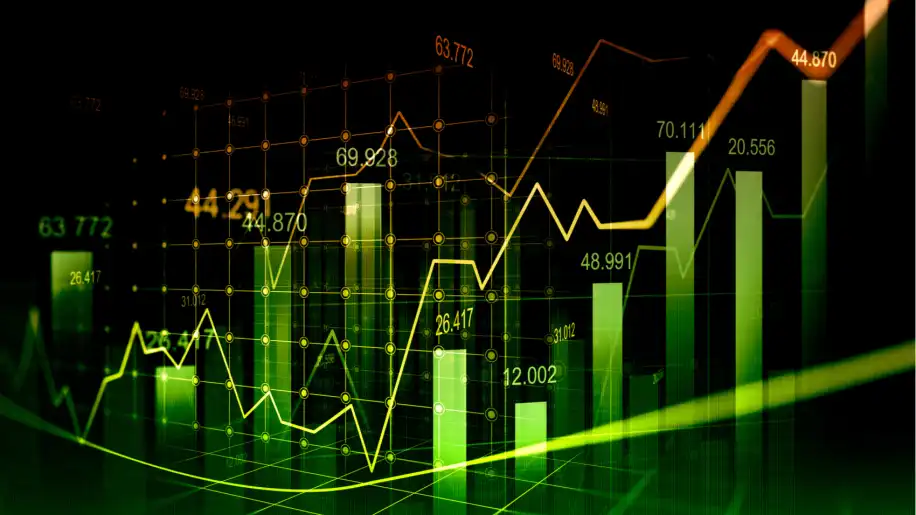


Uma ação é um título patrimonial que permite aos seus acionistas (pessoas que detem a ação) os direitos e deveres de um sócio da empresa em questão, tais como participar do lucro da companhia (varia de acordo com a porcentagem de ações que possui) e, principalmente, podem ganhar com a valorização do preço das ações no mercado. Isto é, uma ação que você compra hoje a R$ 1,00, amanhã pode estar valendo mais, menos, ou não alterar em relação ao valor atual.


Enfim, não entraremos em termos muito técnicos da área de finanças, o objetivo do estudo é observar o comportamento das ações da globo conforme o tempo e posteriormente tentar prever o comportamento dessas ações para os meses posteriores.

# Lendo os dados e importando as libs 

In [ ]:
import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

In [ ]:
data = pd.read_csv('df.csv')

In [ ]:
data.head()

,Time,D-GLOBO
0,1998-02-11,1540
1,1998-02-12,1510
2,1998-02-13,1480
3,1998-02-14,1490
4,1998-02-15,1480


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Time     234 non-null    object
 1   D-GLOBO  234 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ KB


# Pré processamento

In [ ]:
data['Time'] =  pd.to_datetime(data['Time'], format='%Y-%m-%d') #transformando em datetime 

In [ ]:
data = data.set_index('Time') #transformando em DatetimeIndex 

In [ ]:
data.tail()

,D-GLOBO
Time,
1998-09-28,1170
1998-09-29,1170
1998-09-30,1170
1998-10-01,1170
1998-10-02,1170


In [ ]:
def plotar(title, labelx, labely, x, y, dataset):
  ax = sns.lineplot(x = x, y = y, data = dataset)
  ax.figure.set_size_inches(12,8)
  ax.set_title(title, loc = 'left', fontsize = 18)
  ax.set_xlabel(labelx, fontsize = 14)
  ax.set_ylabel(labely, fontsize = 14);

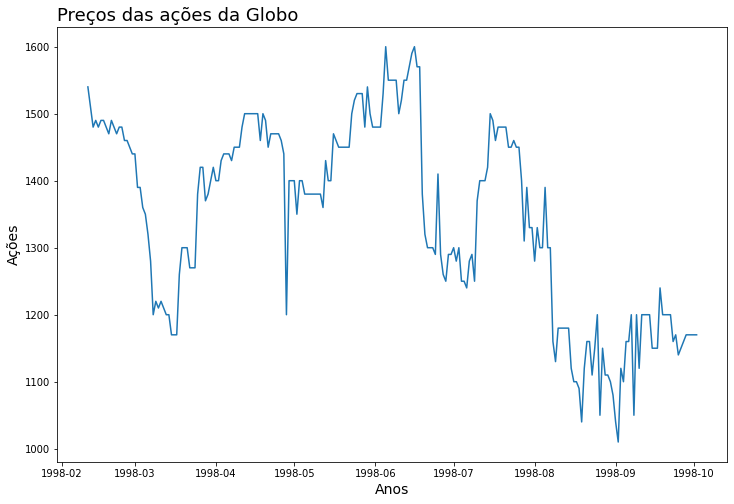

In [ ]:
plotar('Preços das ações da Globo','Anos','Ações',data.index,
       'D-GLOBO',data)

a série não apresenta sazonalidade clara e com tendência aleatória de descrescimento aparentemente. Será feito testes formais para considerar a série como estacionária ou não.

# Identificação de modelos candidatos

###Checar estacionariedade dos dados

##Média Móvel
É uma técnica comum em séries temporais que tem como objetivo eliminar o ruído, suavizando a curva dos dados como mostrado abaixo. A média móvel faz a média aritmética das k observações mais recentes.

In [ ]:
def media_movel(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean() #k=30
    rolstd = timeseries.rolling(30).std()

    #Plot rolling statistics:
    plt.figure(figsize = (12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='média móvel')
    std = plt.plot(rolstd, color='black', label = 'desvio padrão')
    plt.legend(loc='best')
    plt.title('média móvel e desvio padrão')
    plt.show(block=False)


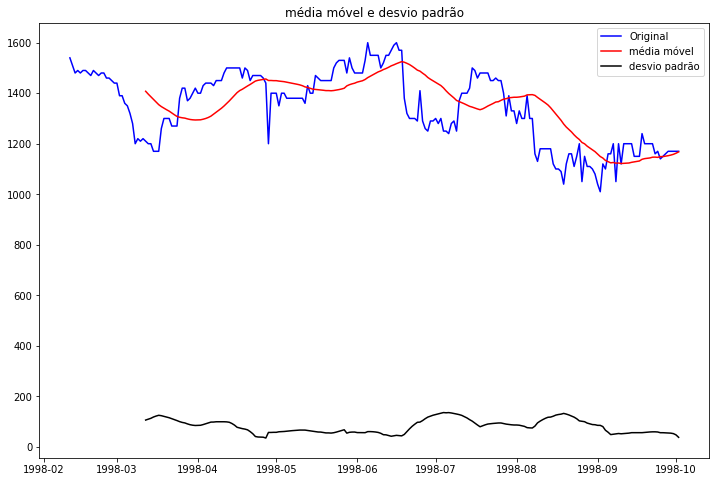

In [ ]:
media_movel(data)

## Teste de dickey-fuller aumentado
Usado para verificar se há uma raíz unitária. Se não pudermos rejeitar a hipótese nula, é dito que o processo tem uma raíz unitária e isso significa que o processo não é estacionário (conceito importante para o funcionamento de alguns modelos)


In [ ]:
resultado = sm.tsa.adfuller(data['D-GLOBO'])
print('p-value: {}'.format(resultado[1]))

p-value: 0.3423497422456165


como o p-value é 0.34, temos evidências o suficiente para dizer que a série não é estacionária, para tanto, será feito a diferenciação da série no intuito de que a série passe a ser estacionária

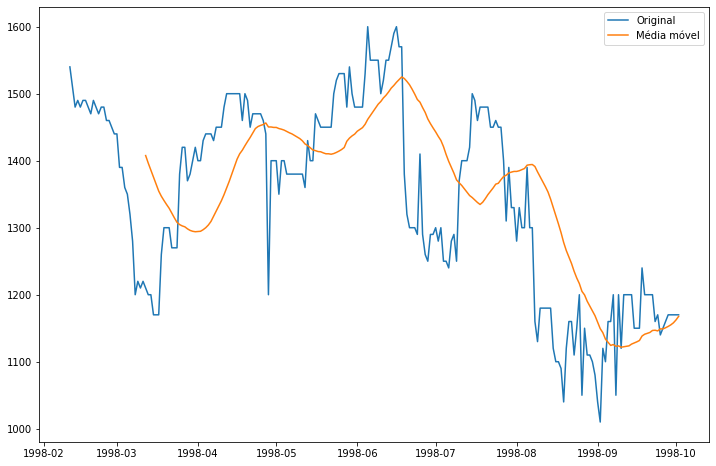

In [ ]:
moving_avg = data.rolling(30).mean()

plt.figure(figsize = (12, 8))
plt.plot(data, label='Original')
plt.plot(moving_avg, label='Média móvel')
plt.legend(loc='best')

###decompondo os dados

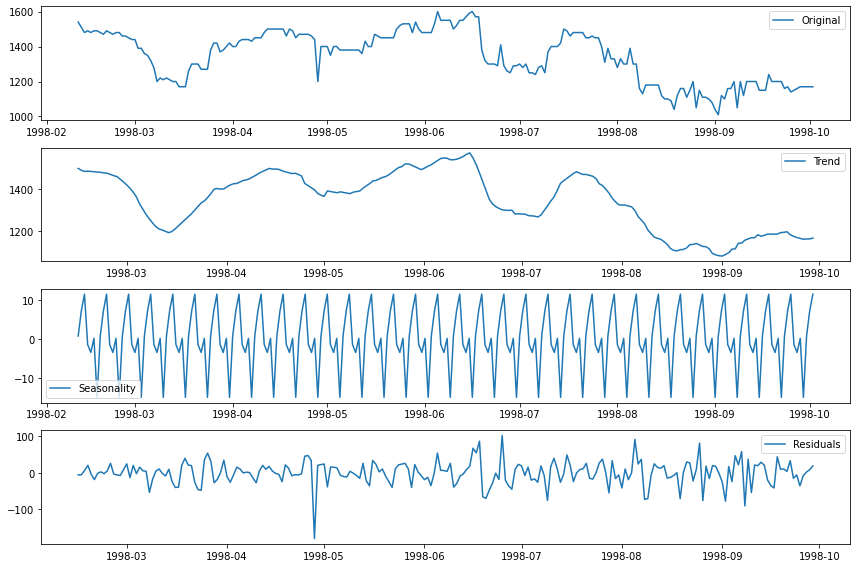

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (12, 8))
plt.subplot(411)
plt.plot(data, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

O que mais chama atenção é a sazonalidade, pois há nos dados notória sazonalidade, corroborando com o teste adf de que os dados não são estacionários.

###transformando os dados

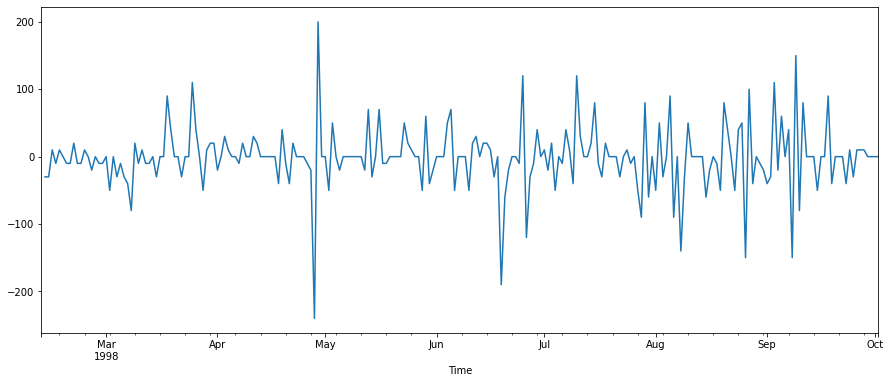

In [ ]:
#diferenciação
data['D-GLOBO_diff'] = data['D-GLOBO'].diff()
data['D-GLOBO_diff'].plot()

###teste adfuller

In [ ]:
resultado = sm.tsa.adfuller(data['D-GLOBO_diff'].dropna())
print('p-value: {}'.format(resultado[1]))

p-value: 2.7110482379640903e-06


In [ ]:
print(f'Resultado: A série temporal é {"não " if resultado[1] > 0.05 else ""}estacionária.')


Resultado: A série temporal é estacionária.


##Definição de P, D e Q

P, é o parâmetro associado ao aspecto auto-regressivo do modelo, isto é, mostra como os valores passados afetam no período atual. D, se refere a  diferenciações feitas na série temporal. E por fim, Q, se refere a média móvel do modelo, que busca capturar o efeito do ruído na série.

Os termos P e Q podem ser obtidos através da análise dos gráficos de Função de Autocorrelação Amostral e Função de Autocorrelação Parcial Amostral.

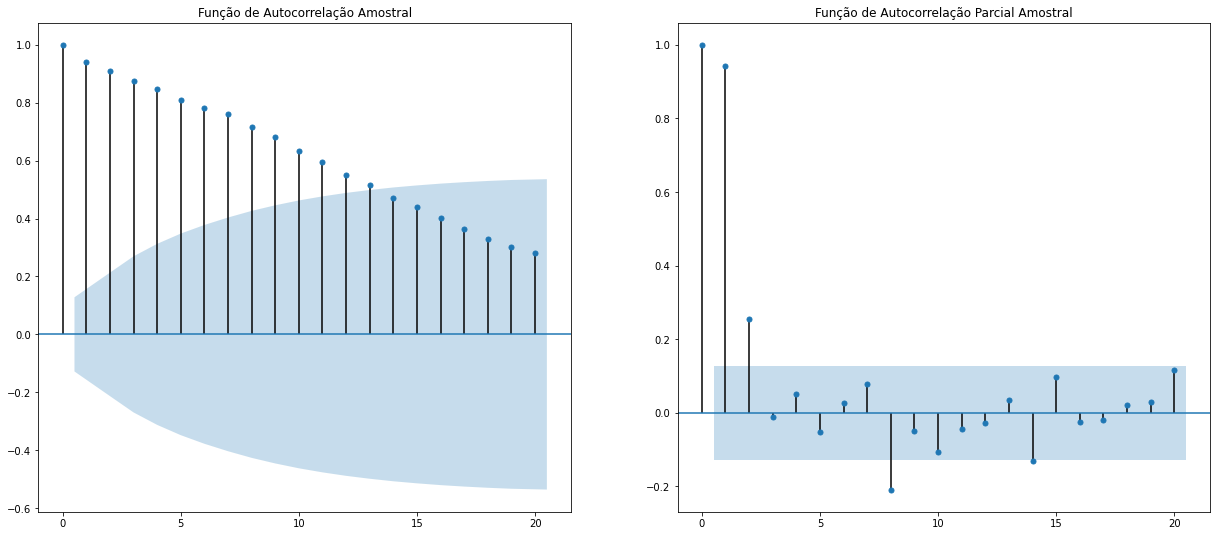

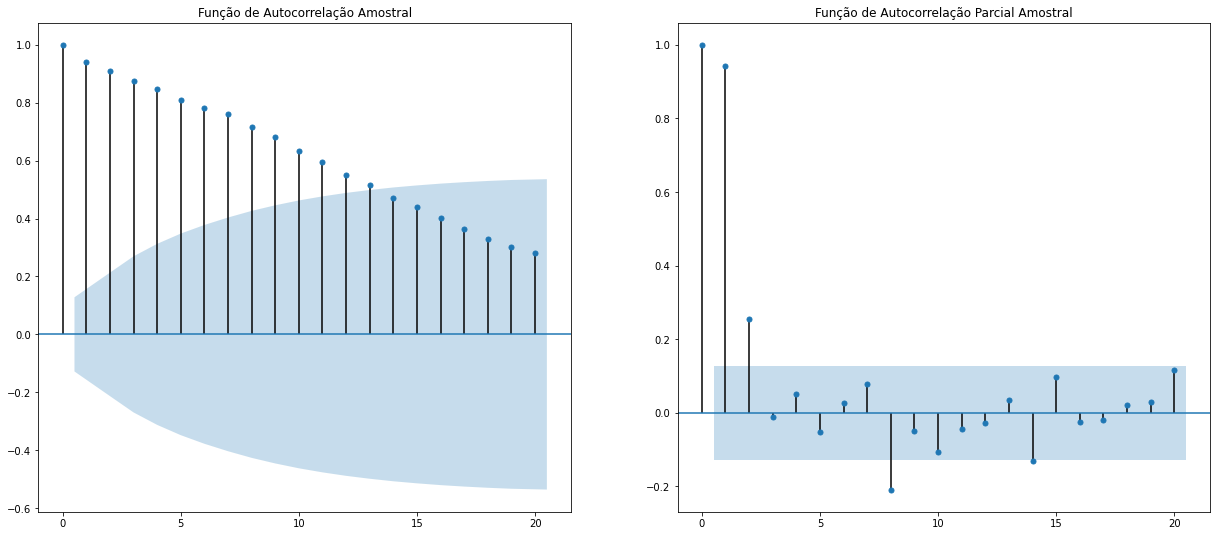

In [ ]:
plt.figure(figsize = (21, 9))

ax1 = plt.subplot(1,2,1)
plot_acf(data['D-GLOBO'].dropna(), lags=20, title = 'Função de Autocorrelação Amostral', ax = ax1)

ax2 = plt.subplot(1,2,2)
plot_pacf(data['D-GLOBO'].dropna(), lags=20, title = 'Função de Autocorrelação Parcial Amostral', ax = ax2)



O gráfico de função de autocorrelação nos apresenta uma queda lenta, o que indica que os dados não são estacionários.

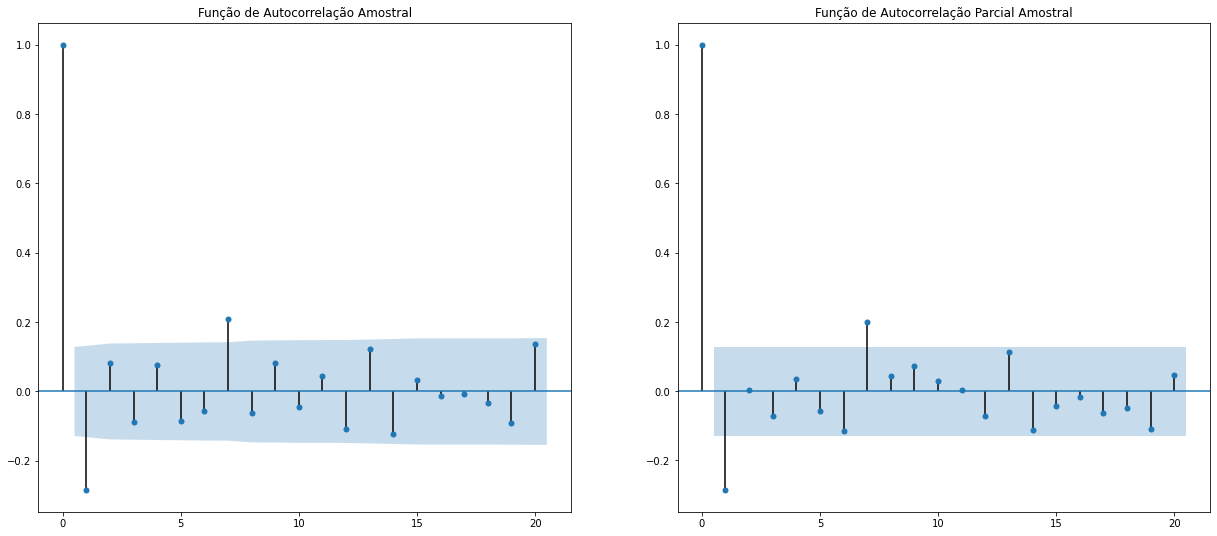

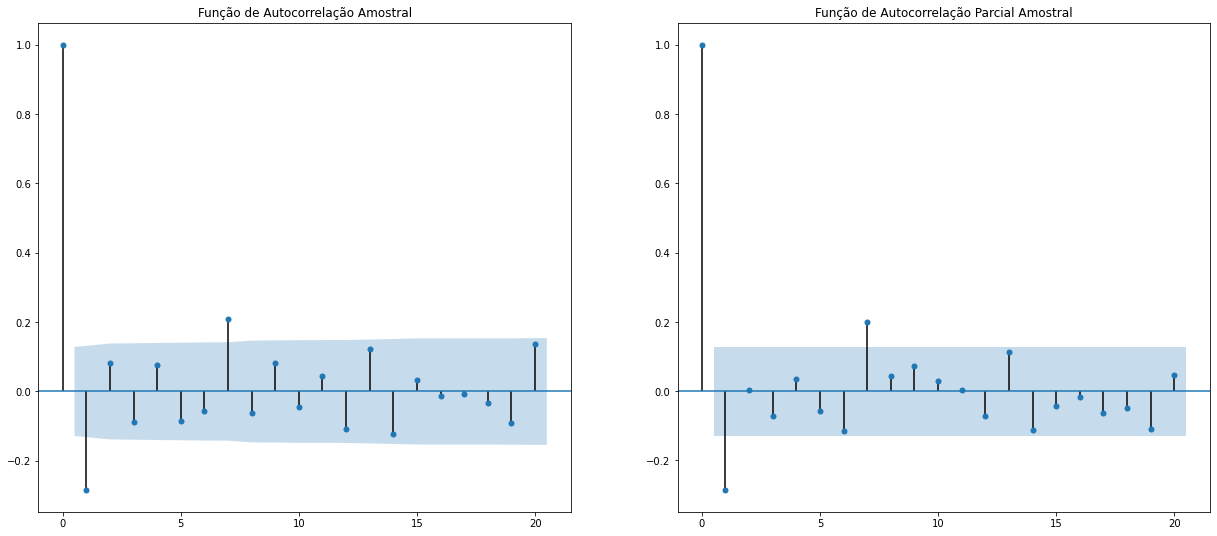

In [ ]:
plt.figure(figsize = (21, 9))

ax1 = plt.subplot(1,2,1)
plot_acf(data['D-GLOBO_diff'].dropna(), lags=20, title = 'Função de Autocorrelação Amostral', ax = ax1)

ax2 = plt.subplot(1,2,2)
plot_pacf(data['D-GLOBO_diff'].dropna(), lags=20, title = 'Função de Autocorrelação Parcial Amostral', ax = ax2)



Há um decréscimo rápido na função de autocorrelação com truncamento no lag 1. Isto é um indicativo de posso decidir que o D é 1.

A autocorrelação parcial nos ajuda a determinar o valor de P, no gráfico podemos ver que até o lag1 há uma autocorrelação significativa (e posteriormente no lag 7 mas ainda não levarei em consideração.

Apesar dos indicativos, irei testar o ARIMA com várias configurações diferentes para fazer a comparação.

# Estimativa dos parâmetros

In [ ]:
data = data.drop('D-GLOBO_diff', axis=1)

In [ ]:
comeco_train = '1998-03-13'
termino_train = '1998-08-15'
comeco_test = '1998-08-16'
termino_test = '1998-10-02'

df_train = data[comeco_train:termino_train]
df_test = data[comeco_test:termino_test]
df_train.shape, df_test.shape

((156, 1), (48, 1))

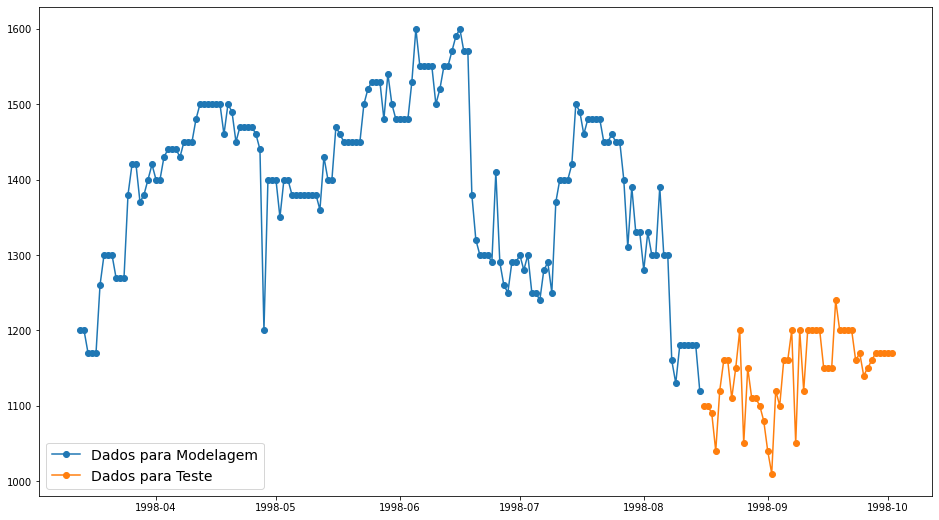

In [ ]:
plt.figure(figsize = (16, 9))

plt.plot(df_train['D-GLOBO'], 'o-')
plt.plot(df_test['D-GLOBO'], 'o-')

legenda = ('Dados para Modelagem', 'Dados para Teste')
plt.legend(legenda, loc = 'lower left', prop = {'size': 14})


In [ ]:
modelo1 = ARIMA(df_train['D-GLOBO'], freq='D', order=(1,1,1)).fit(disp=0)

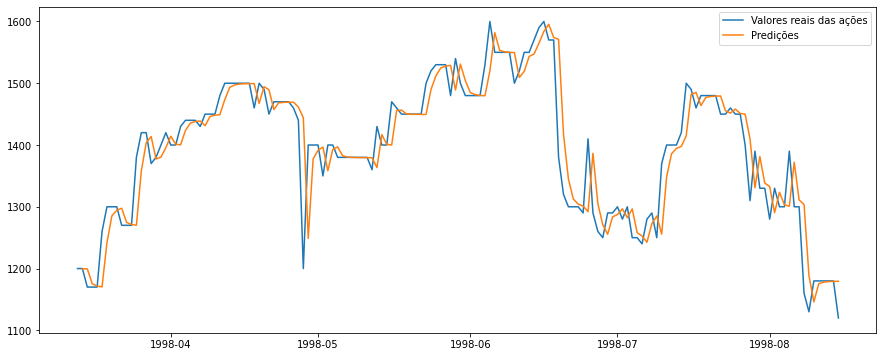

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(df_train['D-GLOBO'])
plt.plot(modelo1.predict(typ='levels'))
plt.legend(['Valores reais das ações', 'Predições'])

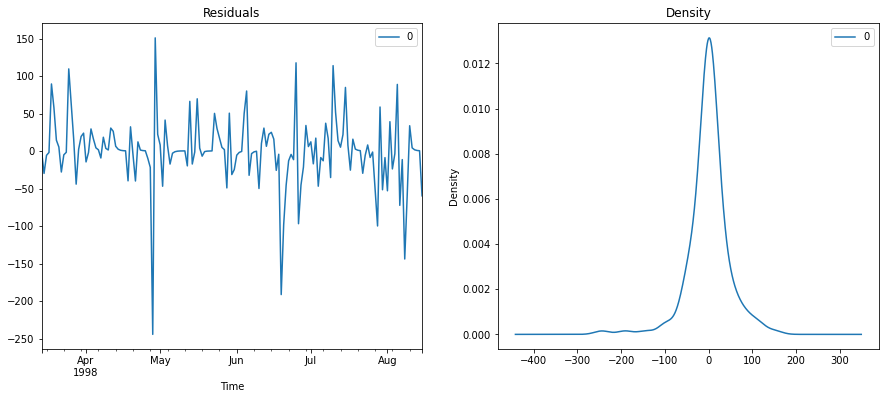

In [ ]:
residuos = pd.DataFrame(modelo1.resid)
fig, ax = plt.subplots(1,2)
residuos.plot(title="Residuals", ax=ax[0])
residuos.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Pelo menos os resíduos parecem ser aleatórios, com média zero e variância uniforme.

# Teste de modelo

In [ ]:
modelo1 = ARIMA(df_train['D-GLOBO'], freq='D', order=(1,1,1)).fit(disp=0)

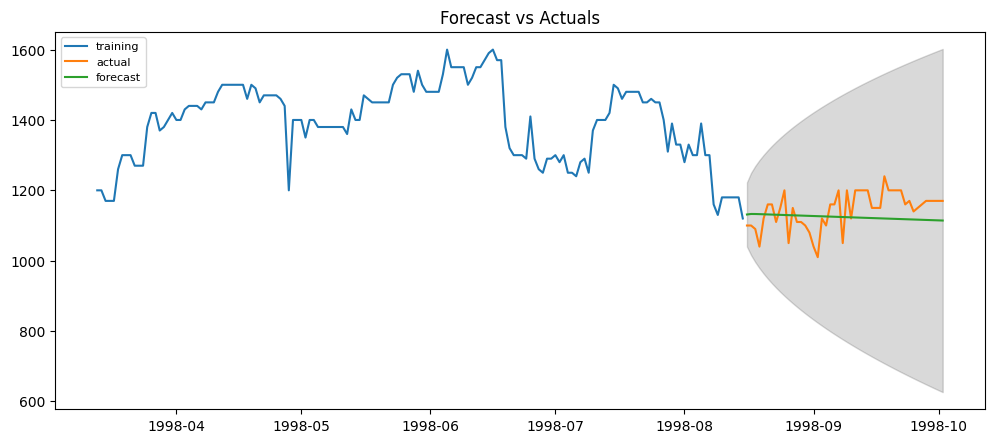

In [ ]:
# Forecast
fc, se, conf = modelo1.forecast(48, alpha=0.05)

# intervalo de confiança
fc_series = pd.Series(fc, index=df_test.index)
lower_series = pd.Series(conf[:, 0], index=df_test.index)
upper_series = pd.Series(conf[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Avaliação do modelo

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

mae = mean_absolute_error(df_test, fc_series)
mape = mean_absolute_percentage_error(df_test, fc_series)

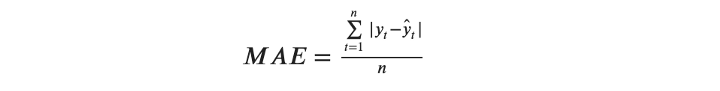


In [ ]:
mae

50.801335708279744

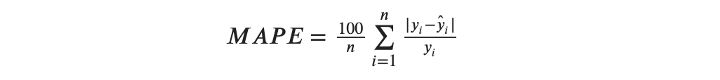

A interpretação do MAE é simples pois ele permanece na mesma escala, então o modelo está errando, em média R$ 50,80 para mais ou para menos em relação ao valor correto.

In [ ]:
mape

0.04438358706868547

o resultado significa que o modelo faz previsões que, em média, a diferença entre o valor previsto e o real equivale a 4% do valor real tanto para mais quanto para menos.